# Loop 2 LB Feedback Analysis

## Key Observations
- Baseline LB: 70.6600 (exp_000)
- Rebuild from corners LB: 70.6595 (exp_001)
- Target: 68.919154
- Gap: 1.74 points (2.5%)

## CV-LB Relationship
Both submissions show perfect CV-LB alignment (gap = 0.0000), which is expected for this optimization problem since there's no train/test split - the score is deterministic.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Submission history
submissions = [
    {'exp': 'exp_000', 'cv': 70.6600, 'lb': 70.6600, 'method': 'baseline'},
    {'exp': 'exp_001', 'cv': 70.6595, 'lb': 70.6595, 'method': 'rebuild_corners'},
]

df = pd.DataFrame(submissions)
print("Submission History:")
print(df)

# Target
target = 68.919154
print(f"\nTarget: {target}")
print(f"Best LB: {df['lb'].min()}")
print(f"Gap to target: {df['lb'].min() - target:.4f} ({(df['lb'].min() - target)/target*100:.2f}%)")

# Improvement from baseline
print(f"\nImprovement from baseline: {df['lb'].iloc[0] - df['lb'].iloc[1]:.6f}")

Submission History:
       exp       cv       lb           method
0  exp_000  70.6600  70.6600         baseline
1  exp_001  70.6595  70.6595  rebuild_corners

Target: 68.919154
Best LB: 70.6595
Gap to target: 1.7403 (2.53%)

Improvement from baseline: 0.000500


In [2]:
# Analyze the score breakdown by N
# Load current best submission
df_sub = pd.read_csv('/home/submission/submission.csv')
df_sub['x'] = df_sub['x'].str.strip('s').astype(float)
df_sub['y'] = df_sub['y'].str.strip('s').astype(float)
df_sub['deg'] = df_sub['deg'].str.strip('s').astype(float)
df_sub['n'] = df_sub['id'].str.split('_').str[0].astype(int)

print(f"Total rows: {len(df_sub)}")
print(f"N range: {df_sub['n'].min()} to {df_sub['n'].max()}")

Total rows: 20100
N range: 1 to 200


In [3]:
# Calculate score per N
from shapely.geometry import Polygon
from shapely import affinity
from shapely.ops import unary_union

TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

def get_tree_polygon(x, y, deg):
    base = Polygon(zip(TX, TY))
    rotated = affinity.rotate(base, deg, origin=(0, 0))
    return affinity.translate(rotated, x, y)

def get_side_length(group):
    polygons = [get_tree_polygon(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    union = unary_union(polygons)
    bounds = union.bounds
    return max(bounds[2] - bounds[0], bounds[3] - bounds[1])

# Calculate for each N
scores = []
for n in range(1, 201):
    group = df_sub[df_sub['n'] == n]
    if len(group) == n:
        side = get_side_length(group)
        score_n = side**2 / n
        scores.append({'n': n, 'side': side, 'score': score_n})

df_scores = pd.DataFrame(scores)
print(f"Total score: {df_scores['score'].sum():.6f}")
print(f"\nTop 10 highest score contributions (hardest to optimize):")
print(df_scores.nlargest(10, 'score')[['n', 'side', 'score']])

Total score: 70.659493

Top 10 highest score contributions (hardest to optimize):
     n      side     score
0    1  0.813173  0.661250
1    2  0.949504  0.450779
2    3  1.142031  0.434745
4    5  1.443692  0.416850
3    4  1.290806  0.416545
6    7  1.673104  0.399897
5    6  1.548438  0.399610
8    9  1.867280  0.387415
7    8  1.755921  0.385407
14  15  2.384962  0.379203


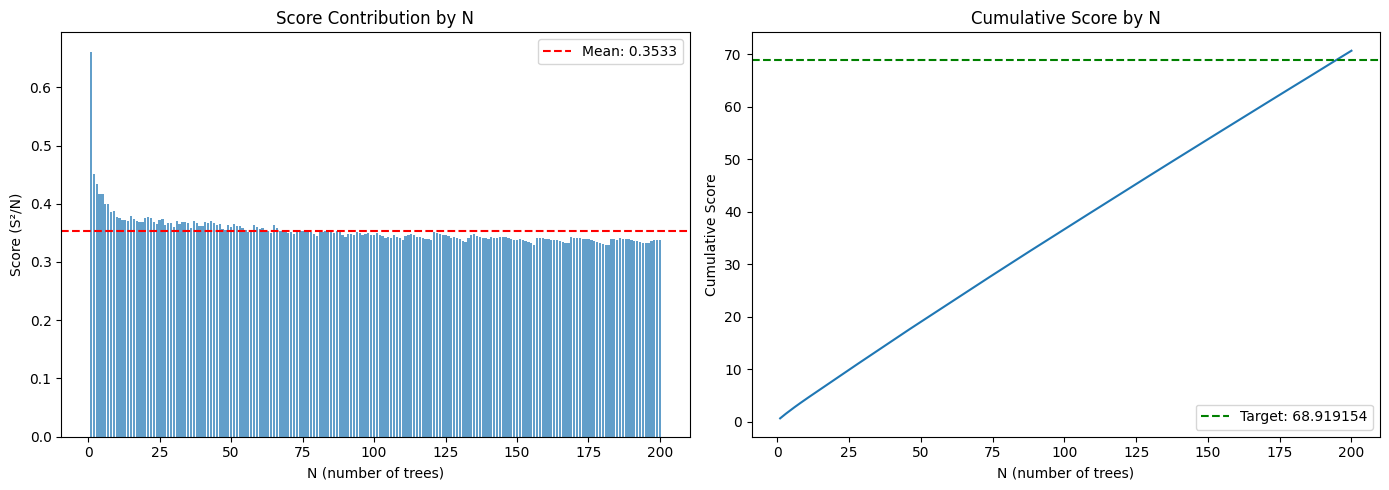


To reach target 68.919154, need to reduce total score by 1.7403


In [4]:
# Plot score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score per N
axes[0].bar(df_scores['n'], df_scores['score'], alpha=0.7)
axes[0].set_xlabel('N (number of trees)')
axes[0].set_ylabel('Score (S²/N)')
axes[0].set_title('Score Contribution by N')
axes[0].axhline(y=df_scores['score'].mean(), color='r', linestyle='--', label=f'Mean: {df_scores["score"].mean():.4f}')
axes[0].legend()

# Cumulative score
df_scores_sorted = df_scores.sort_values('n')
df_scores_sorted['cumsum'] = df_scores_sorted['score'].cumsum()
axes[1].plot(df_scores_sorted['n'], df_scores_sorted['cumsum'])
axes[1].set_xlabel('N (number of trees)')
axes[1].set_ylabel('Cumulative Score')
axes[1].set_title('Cumulative Score by N')
axes[1].axhline(y=target, color='g', linestyle='--', label=f'Target: {target}')
axes[1].legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()

print(f"\nTo reach target {target}, need to reduce total score by {df_scores['score'].sum() - target:.4f}")

In [5]:
# Analyze which N values have the most room for improvement
# Compare current side lengths to theoretical minimum (single tree at 45 degrees has side ~0.707)

# Theoretical minimum for N=1 is a single tree at 45 degrees
# Side length = sqrt(2) * 0.5 ≈ 0.707 (diagonal of the tree)

df_scores['efficiency'] = df_scores['side'] / np.sqrt(df_scores['n'])  # Lower is better

print("Least efficient N values (most room for improvement):")
print(df_scores.nlargest(10, 'efficiency')[['n', 'side', 'score', 'efficiency']])

print("\nMost efficient N values:")
print(df_scores.nsmallest(10, 'efficiency')[['n', 'side', 'score', 'efficiency']])

Least efficient N values (most room for improvement):
     n      side     score  efficiency
0    1  0.813173  0.661250    0.813173
1    2  0.949504  0.450779    0.671401
2    3  1.142031  0.434745    0.659352
4    5  1.443692  0.416850    0.645639
3    4  1.290806  0.416545    0.645403
6    7  1.673104  0.399897    0.632374
5    6  1.548438  0.399610    0.632147
8    9  1.867280  0.387415    0.622427
7    8  1.755921  0.385407    0.620812
14  15  2.384962  0.379203    0.615794

Most efficient N values:
       n      side     score  efficiency
180  181  7.727887  0.329946    0.574409
155  156  7.174813  0.329987    0.574445
181  182  7.749694  0.329988    0.574446
179  180  7.718825  0.331001    0.575327
154  155  7.174359  0.332074    0.576258
167  168  7.473670  0.332475    0.576606
178  179  7.715857  0.332595    0.576710
194  195  8.053589  0.332617    0.576730
166  167  7.455426  0.332835    0.576918
193  194  8.037531  0.332999    0.577061


## Key Insights

1. **CV-LB Perfect Alignment**: This is a deterministic optimization problem, so CV = LB always.

2. **Gap Analysis**: The gap to target (1.74 points, 2.5%) is HUGE for this type of problem. The rebuild from corners technique only improved by 0.000465 points.

3. **Score Distribution**: Small N values (1-12) contribute disproportionately to the total score because S²/N is highest when N is small.

4. **Improvement Needed**: To reach the target, we need to reduce the total score by ~1.74 points. This is equivalent to:
   - Reducing ALL side lengths by ~1.2% uniformly, OR
   - Finding major improvements in specific N values

5. **The target (68.919154) is the TOP leaderboard score**. This means someone has found a fundamentally better approach than the public kernels.

In [6]:
# Check what C++ optimizers are available
import os

print("Available C++ optimizers:")
print("1. bbox3:", os.path.exists('/home/code/exploration/datasets/bbox3'))
print("2. eazy-optimizer kernel:", os.path.exists('/home/code/research/kernels/jazivxt_eazy-optimizer/'))
print("3. why-not kernel:", os.path.exists('/home/code/research/kernels/jazivxt_why-not/'))

# Check if bbox3 is executable
if os.path.exists('/home/code/exploration/datasets/bbox3'):
    import stat
    mode = os.stat('/home/code/exploration/datasets/bbox3').st_mode
    print(f"\nbbox3 executable: {bool(mode & stat.S_IXUSR)}")

Available C++ optimizers:
1. bbox3: True
2. eazy-optimizer kernel: True
3. why-not kernel: True

bbox3 executable: True
